In [2]:
import numpy as np
import matplotlib.pyplot as plt 
import pyaudio
import wave
import struct

from bitstring import BitStream, BitArray

In [3]:
CHUNK_SIZE = 1024
BYTE_LENGTH = 8
def read_file(path):
    stream = open(path, 'rb', buffering=CHUNK_SIZE)
    peek_result = stream.peek()
    (samples, channels, samplerate) = struct.unpack('IHH', peek_result[:8])
    print("Samples: {}\nChannels: {}\nSamplerate: {}".format(samples, channels, samplerate))
    read_data = stream.read() # first chunk
    stream.close()
    print("Length of read chunk: {}".format(len(read_data)))
    b = BitArray(read_data[0:])
    h = { 'samples': samples, 'channels': channels, 'samplerate': samplerate, 'binary': b  }
    return h

In [4]:
def plot(values, NFFT=512, Fs=18000, noverlap=100):
    fig, (ax1, ax2) = plt.subplots(figsize=(15, 10), nrows=2)
    plt.title("Sound Waves [Pseudo Deocded]") 
    plt.xlabel("Samples") 
    ax1.plot(values, color='b')
    Pxx, freqs, bins, im = ax2.specgram(values, NFFT=NFFT, Fs=Fs, noverlap=noverlap)
    plt.show() 

In [5]:
rfh = read_file("f:\\22 Code Playground\\Matrix PON Reverse Engineering\\Sound\\Dialogues\\nsd_en_158_testfile_02")
start_offset = (16*4)
test_length = rfh['samples']
print("Reading {} bytes from {} byte".format(test_length, start_offset))
test = rfh['binary'][start_offset:start_offset+(test_length*16)]

Samples: 73476
Channels: 1
Samplerate: 18000
Length of read chunk: 74048
Reading 73476 bytes from 64 byte


In [6]:
def factorize(stream, length, factor=4, signed=True):
    x = 0
    ratio = BYTE_LENGTH / factor
    new_values = []
    while x < (length * ratio):
        new_values.append(stream[factor*x:factor*(x+1)])
        x += 1
    if signed:
        values_to_plot = [i.int for i in new_values]
    else:
        values_to_plot = [i.uint for i in new_values]
    print("Read {} values w/ bit factor = {}".format(len(values_to_plot), factor))
    return values_to_plot

Read 146952 values w/ bit factor = 4


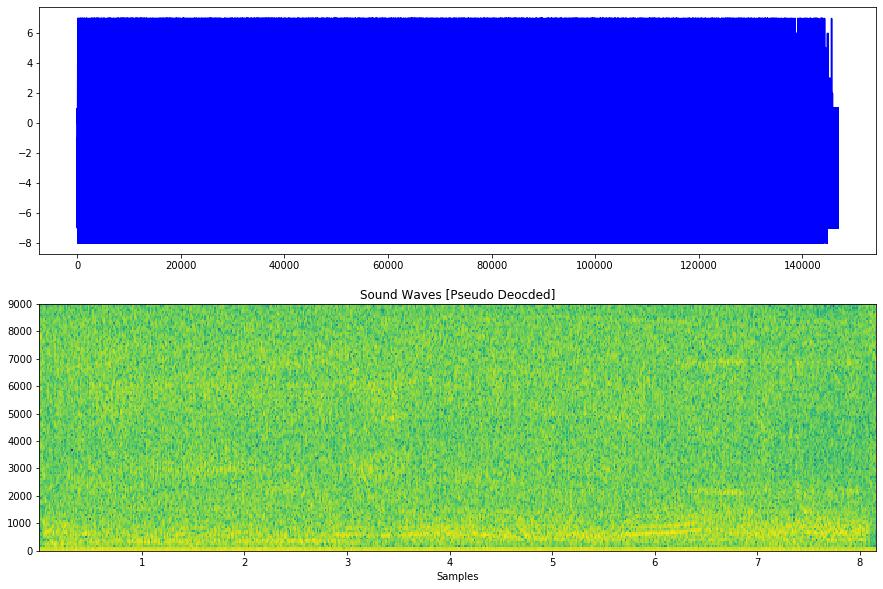

In [28]:
vtp = factorize(test, test_length)
plot(vtp, NFFT=256, Fs=18000, noverlap=10)

In [9]:
def save(path, values):
    save_4bit = open(path, "wb")
    for i in values:
        save_4bit.write(struct.pack('b',i))
    save_4bit.close()

save("f:\\22 Code Playground\\Matrix PON Reverse Engineering\\Sound\\Dialogues\\nsd_en_158_testfile_01__4bit", vtp)

Read 73476 values w/ bit factor = 8


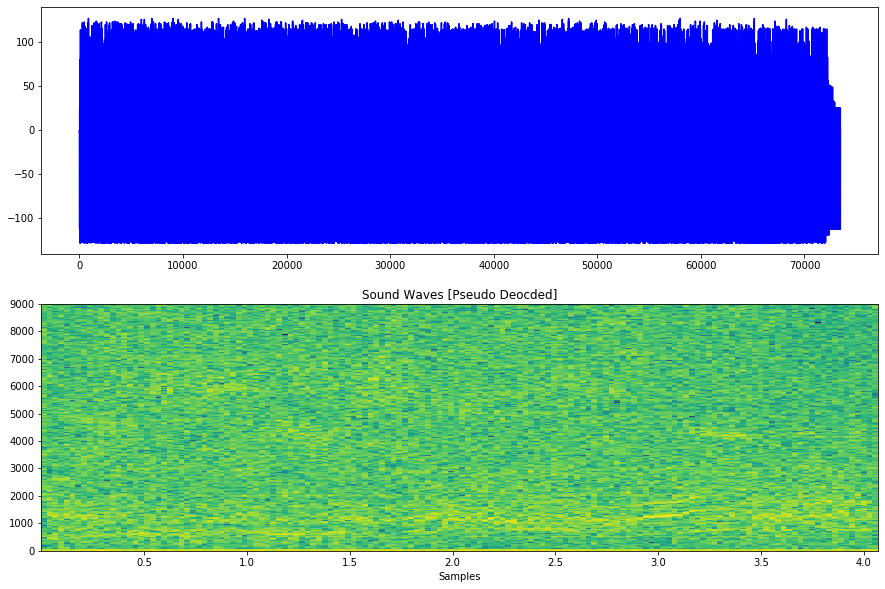

In [10]:
vtp = factorize(test, test_length, factor=8)
plot(vtp, NFFT=512, noverlap=10)

Read 293904 values w/ bit factor = 2


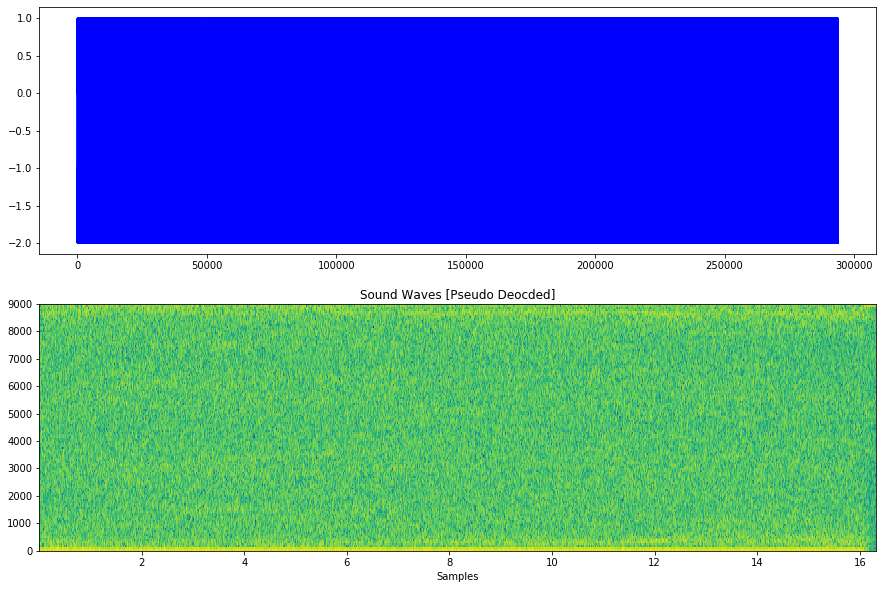

In [11]:
vtp = factorize(test, test_length, factor=2)
plot(vtp, NFFT=256, Fs=18000)

# Test ADPCM decoding

In [21]:
index_table = [0xff, 0xff, 0xff, 0xff, 2, 4, 6, 8,
                0xff, 0xff, 0xff, 0xff, 2, 4, 6, 8]

step_size_table = [7, 8, 9, 10, 11, 12, 13, 14, 16, 17,
19, 21, 23, 25, 28, 31, 34, 37, 41, 45,
50, 55, 60, 66, 73, 80, 88, 97, 107, 118,
130, 143, 157, 173, 190, 209, 230, 253, 279, 307,
337, 371, 408, 449, 494, 544, 598, 658, 724, 796,
876, 963, 1060, 1166, 1282, 1411, 1552, 1707, 1878, 2066,
2272, 2499, 2749, 3024, 3327, 3660, 4026, 4428, 4871, 5358,
5894, 6484, 7132, 7845, 8630, 9493, 10442, 11487, 12635, 13899,
15289, 16818, 18500, 20350, 22385, 24623, 27086, 29794, 32767]

In [13]:
x = 0
factor =8 
length = test_length
stream = test
ratio = BYTE_LENGTH / factor
new_values = []
while x < (length * ratioc):
    new_values.append(stream[factor*x:factor*(x+1)])
    x += 1
# plot(vtp, NFFT=512, Fs=36000, noverlap=10)

In [96]:
for nv in new_values:
    a,b = nv[:4], nv[4:]
    print("{} {}".format(a.bin, b.bin))

1111 1111
1111 1111
0000 0000
0000 0000
1001 1001
0000 0000
0000 0000
0000 0000
1001 0001
0000 0000
0000 0000
0000 0000
0000 0000
0000 0000
0000 0000
1001 0001
0001 1001
0000 0000
1001 0001
0000 0000
0000 0000
0000 0000
0000 0000
1001 0000
0000 0001
1001 0001
1001 0001
0000 0000
0000 0000
1001 0000
1011 0010
1100 0011


In [14]:
state = { 'prevsample': 0, 'previndex': 0 }

In [22]:
def adpcm_decode(code):
    index = state['previndex']
    predsample = state['prevsample']
#     print("index: {}\npredsample: {}".format(index, predsample))

    step = step_size_table[state['previndex']]
#     print("Step: {}".format(step))

    diffq = step >> 3;
    if code.uint & 4:
        diffq += step;
    if code.uint & 2:
        diffq += step >> 1;
    if code.uint & 1:
        diffq += step >> 2;
#     print("diffq: {}".format(diffq))

    if( code.uint & 8 ):
        predsample -= diffq
    else:
        predsample += diffq

    if predsample > 32767:
        predsample = 32767
    elif predsample < -32768:
        predsample = -32768

#     print("predsample (upd.): {}".format(predsample))

#     print("code: {}".format(code>>4))
    index += index_table[code[:4].int]
    if index < 0:
        index = 0
    if index > 88:
        index = 88
#     print("index (upd.): {}".format(index))

    state['prevsample'] = predsample;
    state['previndex'] = index;

    return predsample

In [23]:
state = { 'prevsample': 0, 'previndex': 0 }

res_array = []

for nv in new_values:
    a,b = nv[:4], nv[4:]
#     print("{} {}".format(a.bin, b.bin))
#     code = nv.int
    res_array.append(adpcm_decode(nv))

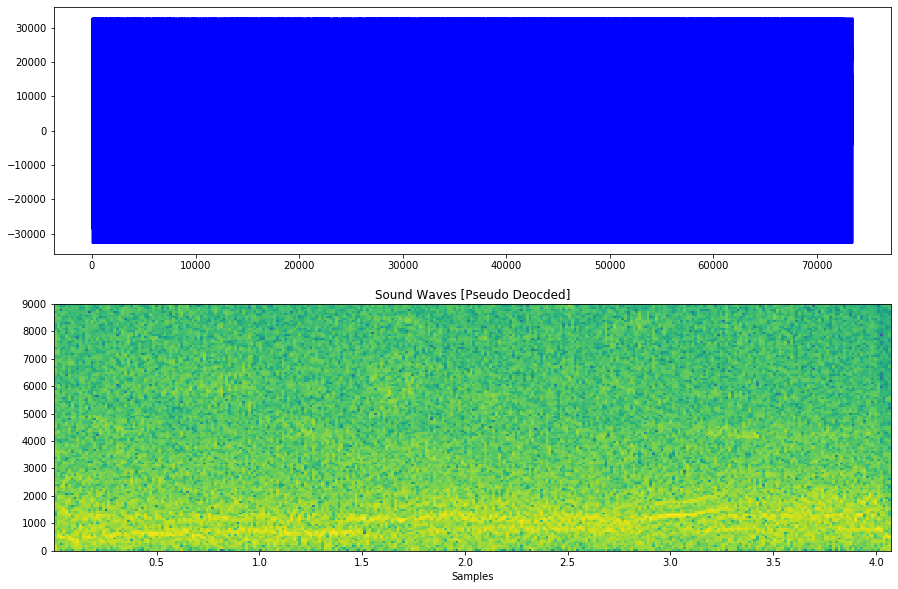

In [27]:
plot(res_array, NFFT=256, Fs=18000, noverlap=10)

In [168]:
def save(path, values):
    save_4bit = open(path, "wb")
    for i in values:
        save_4bit.write(struct.pack('h',i))
    save_4bit.close()

save("f:\\22 Code Playground\\Matrix PON Reverse Engineering\\Sound\\Dialogues\\nsd_en_158_testfile_02__adpcm_test2", res_array)